# Handling Multiple Particle Types (A-B Bonds)

The `freud` library does not explicitly handle particle type data. Instead, users should make use of NumPy array indexing. Below is an example of how to compute order parameters between two types of particles, $A$ and $B$. Here, we assign $A$ a value of 0 and $B$ a value of 1 in the `types` array.

In [1]:
import freud
import numpy as np
np.random.seed(42)

# Generate a system in a hexagonal lattice with random noise.
hex_cell = freud.data.UnitCell.hex()
box, points = hex_cell.generate_system(num_replicas=(24, 10, 1), sigma_noise=0.06)
system = freud.AABBQuery(box, points)

# Generate an array of type ids with 20% type A and 80% type B
type_ids = np.random.choice(2, size=len(points), p=(0.2, 0.8))

We visualize the system:

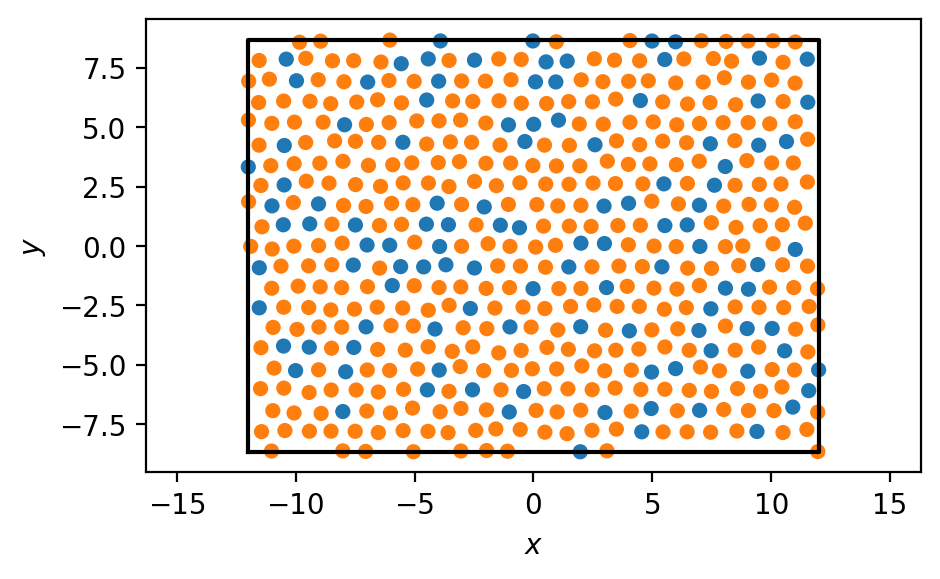

In [2]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
system.plot(ax=ax, c=type_ids, cmap='tab10', vmax=10, s=20)
plt.show()

We want to get all A-B bonds within some cutoff distance. What cutoff distance should we choose?

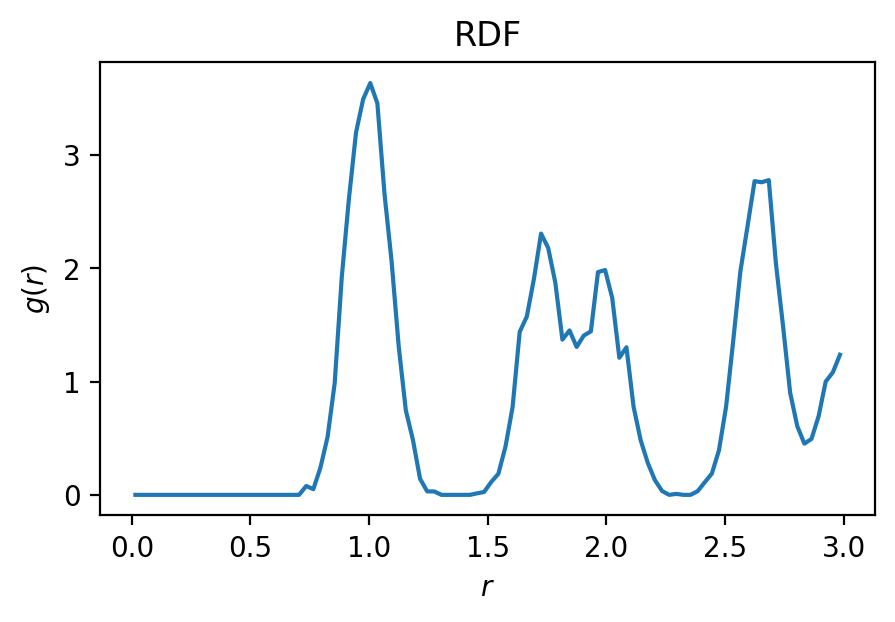

In [3]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
freud.density.RDF(100, 3).compute(system).plot(ax=ax)
plt.show()

Looking at the RDF, we see that the first peak is around 1.0 length units away. We'll use a cutoff of 1.4 length units to capture the entire first peak.

In [4]:
# Find bonds between all particle types
nlist = system.query(points, {'r_max': 1.4}).toNeighborList()
print(len(nlist), 'total bonds')
# Filter to only keep A-B bonds
nlist.filter((type_ids[nlist.query_point_indices] == 0) & (type_ids[nlist.point_indices] == 1))
print(len(nlist), 'A-B bonds')

3360 total bonds
528 A-B bonds


Let's draw the system with the selected bonds, to verify that our calculations look right.

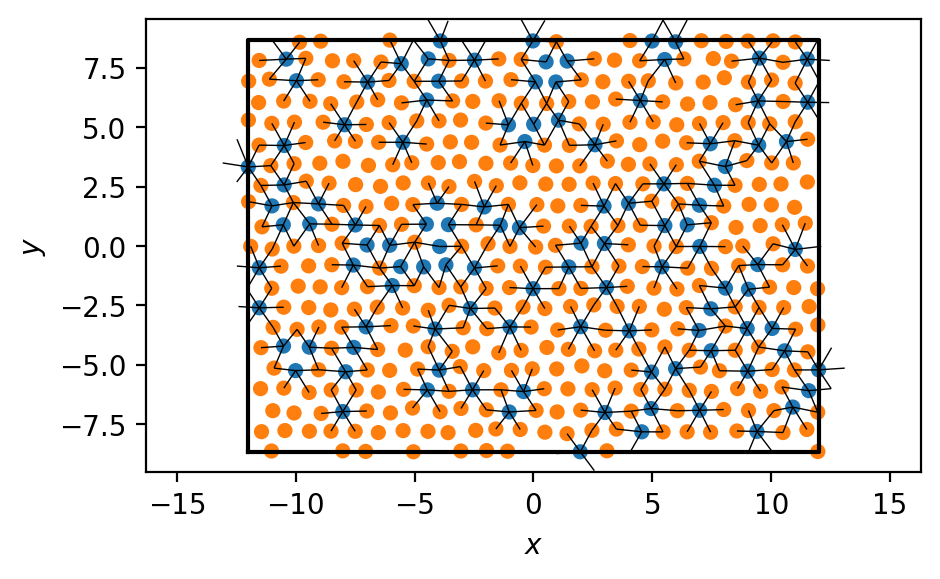

In [5]:
from matplotlib.collections import LineCollection
fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
system.plot(ax=ax, c=type_ids, cmap='tab10', vmax=10, s=20)
lines = [[points[i, :2], points[i, :2] + box.wrap(points[j]-points[i])[:2]] for i, j in nlist]
line_collection = LineCollection(lines, colors='k', linewidths=0.5)
ax.add_collection(line_collection)
plt.show()

Finally, we can compute a hexatic order parameter between types A and B. Only particles of type A have non-zero values of the order parameter.

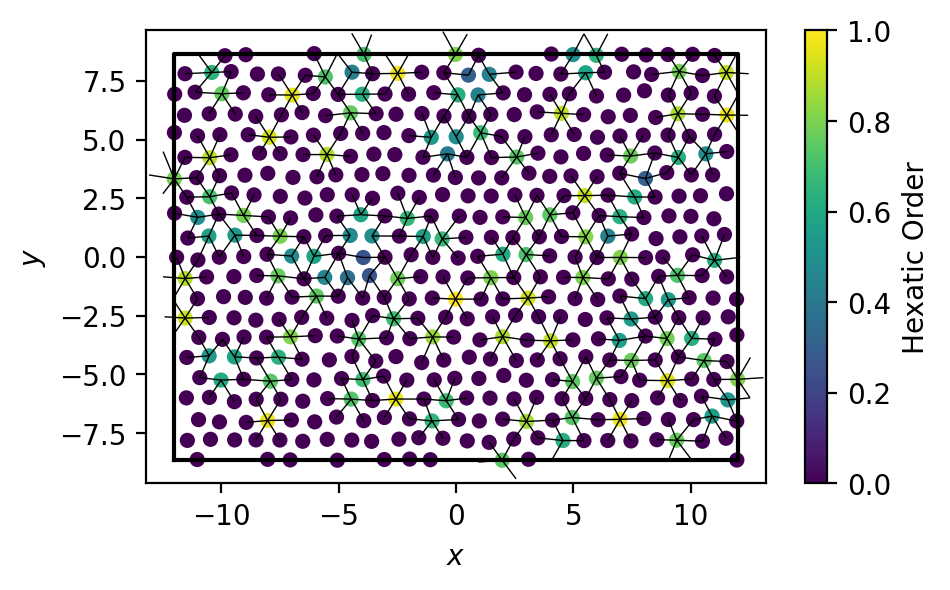

In [6]:
hex_order = freud.order.Hexatic(k=6).compute(system, neighbors=nlist)

fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
box.plot(ax=ax)
plt.scatter(points[:, 0], points[:, 1], c=np.real(hex_order.particle_order), cmap='viridis', s=20, vmax=1, vmin=0)
lines = [[points[i, :2], points[i, :2] + box.wrap(points[j]-points[i])[:2]] for i, j in nlist]
line_collection = LineCollection(lines, colors='k', linewidths=0.5)
ax.add_collection(line_collection)
plt.colorbar(label="Hexatic Order")
plt.show()